<h1> CN Experimente - Clusteringverfahren </h1>
This notebook contains a detailed comparison between the different dimension reduction algorithm (t-SNE, UMAP, PCA, truncated SVD). UMAP delivered the best results for us. In order to be able to compare the results better, a validation function (average of the X and Y coordinates for a certain number of runs) was developed for UMAP. For this reason, we decided to use UMAP in the further course of the project. During the analysis of the different algorithms, the entities and the categories (cat-data) of the entities were also repeatedly merged to the coin data set. However, no visual improvement of the results could be observed. For this reason, we only referred to the coin data set for clustering in the further course of the project. 

Another very interesting insight can be found on the very bottom of this notebook. Therefore we used a very simple RandomForest Classifier zu predict the enddate of a coin with its entitys. It can be stated that a very high accuracy could be achieved, even with this little optimised approach.

In [1]:
import time
import pandas as pd
import umap.umap_ as umap
import umap.utils
import umap.plot
from datetime import datetime
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np

In [2]:
import random
def cross_validation(d, k=40):
    seeds = random.sample(range(0, 100000), k)
    embedding_x = 0
    embedding_y = 0
    for seed in seeds:
        r = umap.UMAP(random_state=seed)
        r.fit(d)
        embedding = r.transform(d)
        embedding_x += embedding[:, 0]
        embedding_y += embedding[:, 1]
    embedding_x = embedding_x / k
    embedding_y = embedding_y / k
    return embedding_x, embedding_y

In [3]:
data = pd.read_csv('..\\data\\analysis_dataset_w_material.csv', sep=";")
del data["Unnamed: 0"]
del data["material_cat"]
data_coins = data["coin"].to_list()
del data["coin"]
# material to category
data["material"] = data["material"].astype("category")
data["material"] = data["material"].cat.codes
for c in data.columns:
    try:
        data[c] = data[c].astype(float)
    except:
        print(c)
del data["findspot"]

findspot


<h3>Presteps - analyzing the data </h3>

<b>Fill ratios:</b>

In [4]:
100 - data.isnull().sum(axis = 0)/len(data)*100

maxdiam            75.257983
mindiam            44.650506
weight             86.073793
material          100.000000
enddate            81.082068
startdate          81.077200
axis               34.703563
denom_cat         100.000000
mint_cat          100.000000
collection_cat    100.000000
dtype: float64

<b> Selected distribution plots </b>

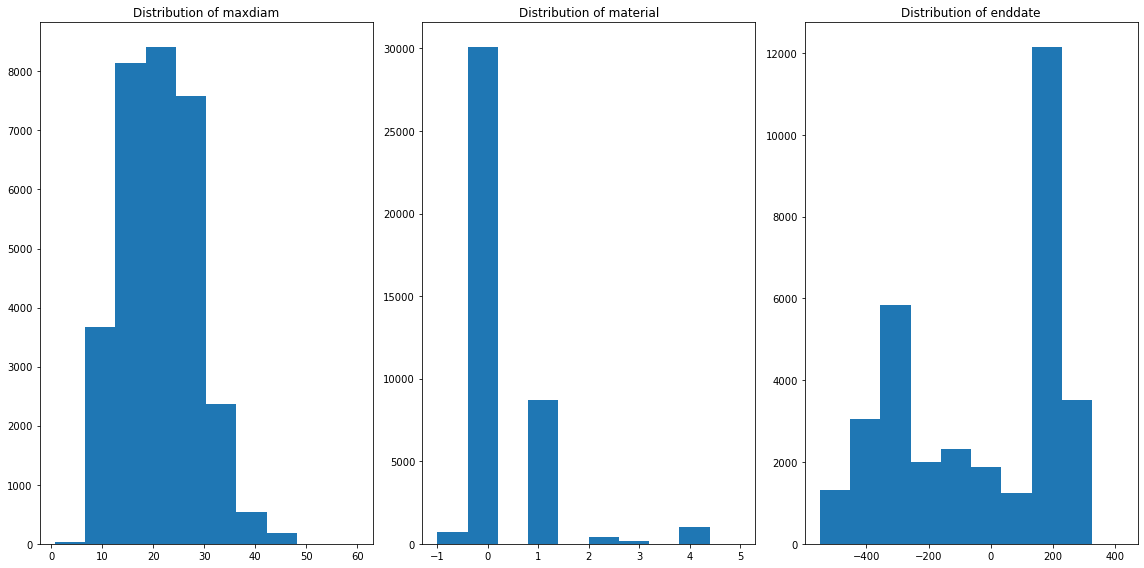

In [5]:
plt.figure(figsize=(16, 8)) 
ax = plt.subplot(1, 3, 1)
ax.hist(data["maxdiam"])
ax.set_title("Distribution of maxdiam")
ax = plt.subplot(1, 3, 2)
ax.hist(data["material"])
ax.set_title("Distribution of material")
ax = plt.subplot(1, 3, 3)
ax.hist(data["enddate"])
ax.set_title("Distribution of enddate")
plt.tight_layout()
plt.show()

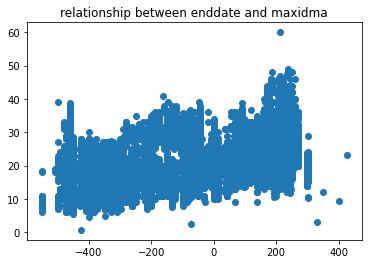

In [29]:
plt.scatter(data["enddate"], data["maxdiam"])
plt.title("relationship between enddate and maxidma")
plt.show()

<b> Correlation matrix </>

In [31]:
data.corr(method="pearson")

,maxdiam,mindiam,weight,material,enddate,startdate,axis,denom_cat,mint_cat,collection_cat
maxdiam,1.000000,0.992253,0.882340,-0.205163,0.578154,0.588155,-0.084342,-0.106551,0.176263,0.008952
mindiam,0.992253,1.000000,0.895087,-0.215160,0.539001,0.554665,-0.114470,-0.172166,0.158777,0.012146
weight,0.882340,0.895087,1.000000,0.015827,0.318304,0.331932,-0.067632,0.042489,0.097108,-0.006709
material,-0.205163,-0.215160,0.015827,1.000000,-0.563980,-0.556093,0.101474,0.602366,-0.173645,-0.085959
enddate,0.578154,0.539001,0.318304,-0.563980,1.000000,0.988925,-0.176219,-0.419234,0.322969,-0.015933
startdate,0.588155,0.554665,0.331932,-0.556093,0.988925,1.000000,-0.191296,-0.402629,0.316640,-0.013642
axis,-0.084342,-0.114470,-0.067632,0.101474,-0.176219,-0.191296,1.000000,0.063638,-0.040207,-0.004551
denom_cat,-0.106551,-0.172166,0.042489,0.602366,-0.419234,-0.402629,0.063638,1.000000,-0.111215,-0.020760
mint_cat,0.176263,0.158777,0.097108,-0.173645,0.322969,0.316640,-0.040207,-0.111215,1.000000,-0.023373
collection_cat,0.008952,0.012146,-0.006709,-0.085959,-0.015933,-0.013642,-0.004551,-0.020760,-0.023373,1.000000


Correlation impications: colleciton cat behaves like an id. Maxdiam and mindiam are extremely high correlated, one of the features (with lower fill raito) should be removed from the dataset. Same situation for startdate and endate. There is also a high correlation between maxdiam/mindiam and weight.

<h2>1. CN Daten ohne Entitäten</h2>

<h3>1.1 Full dataset</h3>

In [6]:
full_data = data.copy()
full_data.columns

Index(['maxdiam', 'mindiam', 'weight', 'material', 'enddate', 'startdate',
       'axis', 'denom_cat', 'mint_cat', 'collection_cat'],
      dtype='object')

<b> Drop nans</b>

In [7]:
#del full_data["findspot"]
full_data = full_data.dropna()
print(full_data.columns)
full_data.shape

Index(['maxdiam', 'mindiam', 'weight', 'material', 'enddate', 'startdate',
       'axis', 'denom_cat', 'mint_cat', 'collection_cat'],
      dtype='object')


(5947, 10)

<h3> Agglomerative Clustering </h3>

In [69]:
agg_clustering =AgglomerativeClustering(n_clusters=10).fit(full_data[['maxdiam', 'mindiam', 'weight', 'material', 'enddate', 'startdate',
       'axis', 'denom_cat', 'mint_cat']])

agg_labels = agg_clustering.labels_

<b> Performing UMAP dimension reduction </b>

In [8]:
x_full, y_full = cross_validation(full_data, 20)

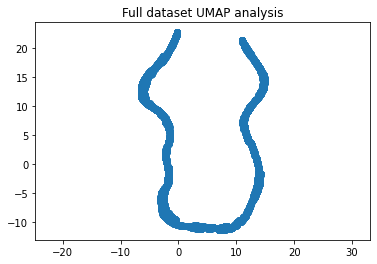

In [9]:
plt.scatter(
    x_full,
    y_full)
plt.gca().set_aspect('equal', 'datalim')
plt.title("Full dataset UMAP analysis")
plt.show()

<b>Performing t-SNE dimension reduction </b>

In [18]:
tsne = TSNE(n_components=2, verbose=2, perplexity=20, n_iter=1000, learning_rate=10)
tsne_results = tsne.fit_transform(full_data)

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 5947 samples in 0.038s...
[t-SNE] Computed neighbors for 5947 samples in 0.091s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5947
[t-SNE] Computed conditional probabilities for sample 2000 / 5947
[t-SNE] Computed conditional probabilities for sample 3000 / 5947
[t-SNE] Computed conditional probabilities for sample 4000 / 5947
[t-SNE] Computed conditional probabilities for sample 5000 / 5947
[t-SNE] Computed conditional probabilities for sample 5947 / 5947
[t-SNE] Mean sigma: 26.347825
[t-SNE] Computed conditional probabilities in 0.455s
[t-SNE] Iteration 50: error = 98.2040482, gradient norm = 0.0000062 (50 iterations in 1.463s)
[t-SNE] Iteration 100: error = 97.8358383, gradient norm = 0.0058098 (50 iterations in 1.335s)
[t-SNE] Iteration 150: error = 77.6811752, gradient norm = 0.0052291 (50 iterations in 1.194s)
[t-SNE] Iteration 200: error = 70.7327652, gradient norm = 0.0033173 (50 iterations in 1.143s)
[

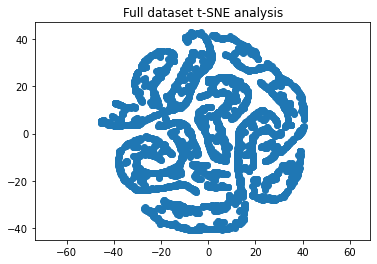

In [25]:
plt.scatter(
    tsne_results[:, 0],
    tsne_results[:, 1])
plt.gca().set_aspect('equal', 'datalim')
plt.title("Full dataset t-SNE analysis")
plt.show()

<b> PCA analysis </b>

In [22]:
pca_full = PCA(n_components=2)
pca_full.fit(full_data)
X_pca_full = pca_full.transform(full_data)

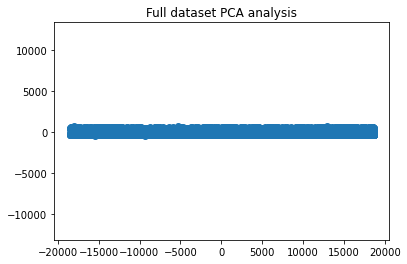

In [29]:
plt.scatter(
    X_pca_full[:, 0],
    X_pca_full[:, 1])
plt.gca().set_aspect('equal', 'datalim')
plt.title("Full dataset PCA analysis")
plt.show()

<b> Delete colection_cat </b> <br> collection_cat includes a lot of different categories. In our case collection is working like a pseudo id

In [7]:
len(full_data["collection_cat"].unique().tolist())

5929

In [8]:
del full_data["collection_cat"]
scaler = StandardScaler()
scaler.fit(full_data)
full_data_standardized = scaler.transform(full_data)

In [9]:
print(full_data.columns)
x_full2, y_full2 = cross_validation(full_data_standardized, 20)

Index(['maxdiam', 'mindiam', 'weight', 'material', 'enddate', 'startdate',
       'axis', 'denom_cat', 'mint_cat'],
      dtype='object')


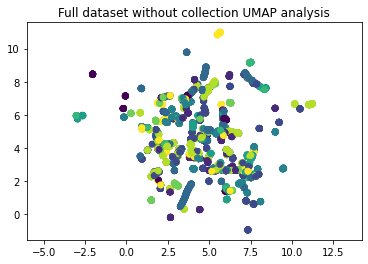

In [70]:
plt.scatter(
    x_full2,
    y_full2, c=agg_labels)
plt.gca().set_aspect('equal', 'datalim')
plt.title("Full dataset without collection UMAP analysis")
plt.show()

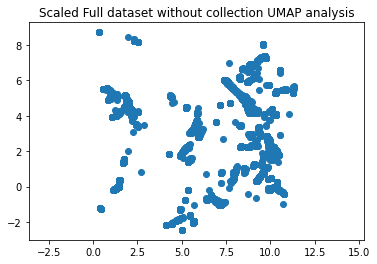

In [11]:
plt.scatter(
    x_full2,
    y_full2)
plt.gca().set_aspect('equal', 'datalim')
plt.title("Scaled Full dataset without collection UMAP analysis")
plt.show()

<b>t-SNE dimension reduction without collection_cat </b>

In [12]:

tsne_full2 = TSNE(n_components=2, verbose=2, perplexity=20, n_iter=1000, learning_rate=10)
tsne_results_full2 = tsne_full2.fit_transform(full_data_standardized)

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 5947 samples in 0.040s...
[t-SNE] Computed neighbors for 5947 samples in 0.315s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5947
[t-SNE] Computed conditional probabilities for sample 2000 / 5947
[t-SNE] Computed conditional probabilities for sample 3000 / 5947
[t-SNE] Computed conditional probabilities for sample 4000 / 5947
[t-SNE] Computed conditional probabilities for sample 5000 / 5947
[t-SNE] Computed conditional probabilities for sample 5947 / 5947
[t-SNE] Mean sigma: 0.248635
[t-SNE] Computed conditional probabilities in 0.147s
[t-SNE] Iteration 50: error = 96.7889633, gradient norm = 0.0000034 (50 iterations in 1.575s)
[t-SNE] Iteration 100: error = 96.7231216, gradient norm = 0.0024781 (50 iterations in 2.706s)
[t-SNE] Iteration 150: error = 78.4301758, gradient norm = 0.0049951 (50 iterations in 2.072s)
[t-SNE] Iteration 200: error = 71.8678665, gradient norm = 0.0033481 (50 iterations in 2.184s)
[t

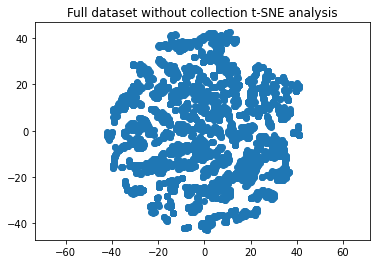

In [13]:
plt.scatter(
    tsne_results_full2[:, 0],
    tsne_results_full2[:, 1])
plt.gca().set_aspect('equal', 'datalim')
plt.title("Full dataset without collection t-SNE analysis")
plt.show()

<b> PCA without collection </b>

In [14]:
pca_full2 = PCA(n_components=2)
pca_full2.fit(full_data_standardized)
X_pca_full2 = pca_full2.transform(full_data_standardized)

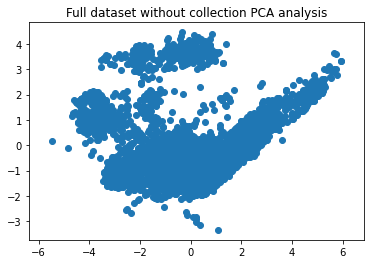

In [15]:
plt.scatter(
    X_pca_full2[:, 0],
    X_pca_full2[:, 1])
plt.gca().set_aspect('equal', 'datalim')
plt.title("Full dataset without collection PCA analysis")
plt.show()

<h2> 1.2 Reduce dimensions - mindiam, axis</h2>

In [17]:
reduced_data = data.copy()
del reduced_data["mindiam"]
del reduced_data["axis"]
#del reduced_data["findspot"]
reduced_data = reduced_data.dropna()
reduced_data.shape
scaler = StandardScaler()
scaler.fit(reduced_data)
reduced_data_standardized = scaler.transform(reduced_data)


In [18]:
x_reduced, y_reduced = cross_validation(reduced_data_standardized, 20)

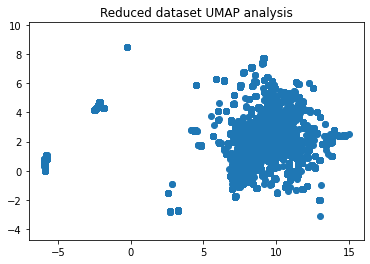

In [19]:
plt.scatter(
    x_reduced,
    y_reduced)
plt.gca().set_aspect('equal', 'datalim')
plt.title("Reduced dataset UMAP analysis")
plt.show()

<h3> 1.3 Select specific dimensions - maxdiam, enddate, material </h3>

In [20]:
selected_data = data.copy()
selected_data = selected_data[["maxdiam", "enddate", "material"]]

In [21]:
print(selected_data.columns)
selected_data = selected_data.dropna()
selected_data.shape

Index(['maxdiam', 'enddate', 'material'], dtype='object')


(28793, 3)

In [22]:
scaler = StandardScaler()
scaler.fit(selected_data)
selected_data_standardized = scaler.transform(selected_data)
x_selected, y_selected = cross_validation(selected_data_standardized, 20)

C:\Users\fredi\Desktop\Uni\Data Challanges\CN\umap\umap\spectral.py:259: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"
C:\Users\fredi\Desktop\Uni\Data Challanges\CN\umap\umap\spectral.py:259: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


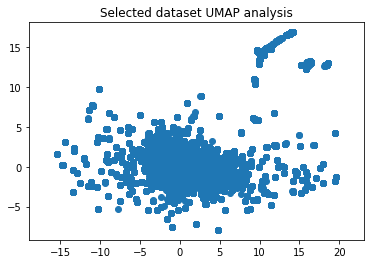

In [23]:
plt.scatter(
    x_selected,
    y_selected)
plt.gca().set_aspect('equal', 'datalim')
plt.title("Selected dataset UMAP analysis")
plt.show()

<h1> 2. Entity dummy data </h1>

In [26]:
entity_dummys = pd.read_csv("..\\2021_06_01_DC_NLP_CNT\\design_dummys.csv", sep=";")
print(entity_dummys.shape)
print(entity_dummys.columns.to_list()[:20])

(28995, 572)
['Unnamed: 0', 'id_coin', 'entity_Abundantia', 'entity_Acrostolium', 'entity_Adler', 'entity_Adlerzepter', 'entity_Aeneas', 'entity_Aequitas', 'entity_Agrippa', 'entity_Aigis', 'entity_Alexander des Großen', 'entity_Altar', 'entity_Amphora', 'entity_Anchialos', 'entity_Anchises', 'entity_Andromeda', 'entity_Anker', 'entity_Annona', 'entity_Antinoos', 'entity_Antiochos I. Soter']


In [27]:
del entity_dummys["Unnamed: 0"]
entity_coins = entity_dummys["id_coin"].to_list()
del entity_dummys["id_coin"]

<h2> 2.1 UMAP dimension reduction </h2>

In [36]:
x_entity_umap, y_entity_umap = cross_validation(entity_dummys, 40)

C:\Users\fredi\Desktop\Uni\Data Challanges\CN\umap\umap\spectral.py:259: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"
C:\Users\fredi\Desktop\Uni\Data Challanges\CN\umap\umap\spectral.py:259: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"
C:\Users\fredi\Desktop\Uni\Data Challanges\CN\umap\umap\spectral.py:259: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to r

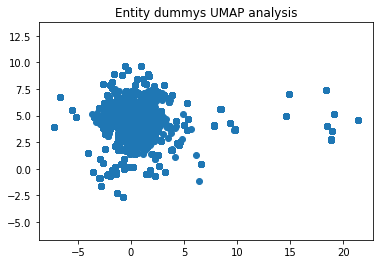

In [37]:
plt.scatter(
    x_entity_umap,
    y_entity_umap)
plt.gca().set_aspect('equal', 'datalim')
plt.title("Entity dummys UMAP analysis")
plt.show()

<b> Analyzing how often feature appears </b>

In [11]:
entity_agg = entity_dummys.sum()
entity_agg = entity_agg.sort_values()

In [12]:
entity_agg.tail(20)

entity_Adler            1487
entity_Zepter           1575
entity_Schlange         1612
entity_Herakles         1630
entity_Efeukranz        1692
entity_Speer            1747
entity_Schild           1862
entity_Füllhorn         2016
entity_Helm             2464
entity_Dionysos         2465
entity_Athena           2579
entity_Caracalla        2647
entity_Apollon          2660
entity_Patera           3121
entity_Gewand           3790
entity_Panzer           5772
entity_Paludamentum     5904
entity_Brustbild        9367
entity_Lorbeerkranz    12722
entity_Kopf            18134
dtype: int64

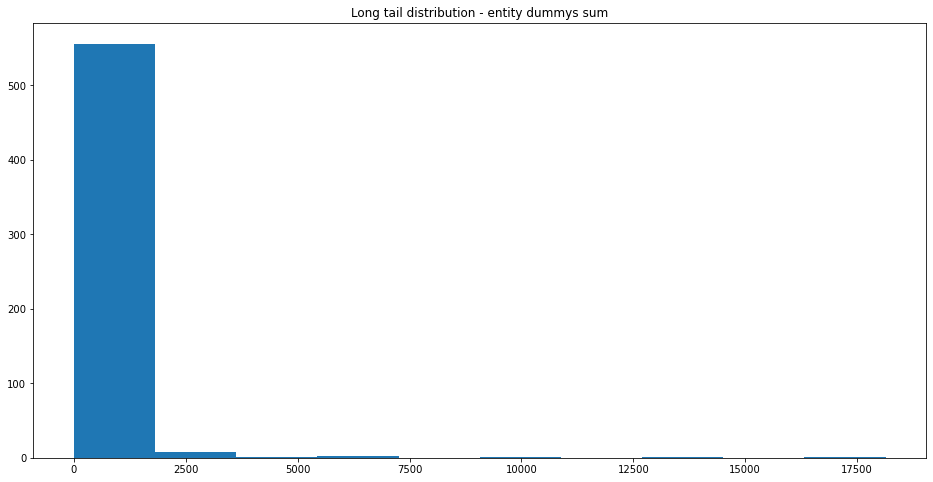

In [32]:
plt.figure(figsize=(16, 8)) 
plt.hist(entity_agg)
plt.title("Long tail distribution - entity dummys sum")
plt.show()

<h2> 2.2 UMAP analysis with top 100 entities </h2>

In [13]:
top100_entities = entity_agg.tail(100).index.tolist()

In [14]:
top100_entity_dummy_data = entity_dummys[top100_entities]
top100_entity_dummy_data.shape

(28995, 100)

In [53]:
x_top100_entity_umap, y_top100_entity_umap = cross_validation(top100_entity_dummy_data, 40)

C:\Users\fredi\Desktop\Uni\Data Challanges\CN\umap\umap\spectral.py:259: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"
C:\Users\fredi\Desktop\Uni\Data Challanges\CN\umap\umap\spectral.py:259: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"
C:\Users\fredi\Desktop\Uni\Data Challanges\CN\umap\umap\spectral.py:259: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to r

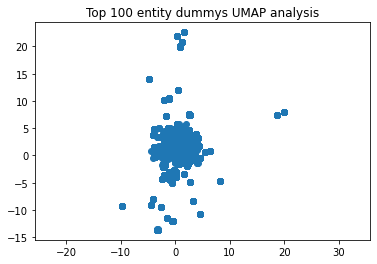

In [54]:
plt.scatter(
    x_top100_entity_umap,
    y_top100_entity_umap)
plt.gca().set_aspect('equal', 'datalim')
plt.title("Top 100 entity dummys UMAP analysis")
plt.show()

<h2> 2.3 t-SNE analysis with entity dummys</h2>

In [55]:
tsne_entity_dummys = TSNE(n_components=2, verbose=2, perplexity=40, n_iter=1000, learning_rate=10)
tsne_results_entity_dummys = tsne_entity_dummys.fit_transform(entity_dummys)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 28995 samples in 9.735s...
[t-SNE] Computed neighbors for 28995 samples in 608.078s...
[t-SNE] Computed conditional probabilities for sample 1000 / 28995
[t-SNE] Computed conditional probabilities for sample 2000 / 28995
[t-SNE] Computed conditional probabilities for sample 3000 / 28995
[t-SNE] Computed conditional probabilities for sample 4000 / 28995
[t-SNE] Computed conditional probabilities for sample 5000 / 28995
[t-SNE] Computed conditional probabilities for sample 6000 / 28995
[t-SNE] Computed conditional probabilities for sample 7000 / 28995
[t-SNE] Computed conditional probabilities for sample 8000 / 28995
[t-SNE] Computed conditional probabilities for sample 9000 / 28995
[t-SNE] Computed conditional probabilities for sample 10000 / 28995
[t-SNE] Computed conditional probabilities for sample 11000 / 28995
[t-SNE] Computed conditional probabilities for sample 12000 / 28995
[t-SNE] Computed conditional probabilities for 

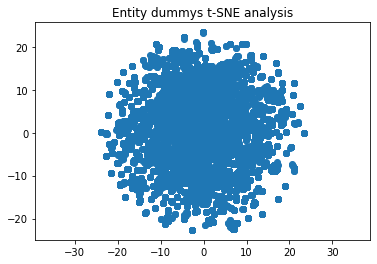

In [56]:
plt.scatter(
    tsne_results_entity_dummys[:, 0],
    tsne_results_entity_dummys[:, 1])
plt.gca().set_aspect('equal', 'datalim')
plt.title("Entity dummys t-SNE analysis")
plt.show()

<h2> 2.4 truncated SVD for sparse data dimension reduction </h2>

In [57]:

svd = TruncatedSVD(n_components=2, n_iter=500, random_state=42)
svd.fit(entity_dummys)
svd_entity_dummy = svd.transform(entity_dummys)

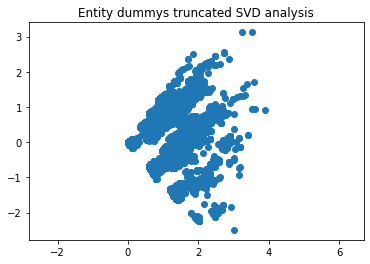

In [58]:
plt.scatter(
    svd_entity_dummy[:, 0],
    svd_entity_dummy[:, 1])
plt.gca().set_aspect('equal', 'datalim')
plt.title("Entity dummys truncated SVD analysis")
plt.show()

<h1> 3. Entity category analysis </h1>

In [28]:
entity_cat_data = pd.read_csv("..\\2021_06_01_DC_NLP_CNT\\entity_cats_prepared.csv", sep=";")

In [29]:
entity_cat_data.columns

Index(['Unnamed: 0', 'id_coin', 'side', 'Cat_I', 'Cat_II', 'Cat_III', 'Cat_IV',
       'Cat_V'],
      dtype='object')

In [30]:
del entity_cat_data["Unnamed: 0"]
entity_cat_coins = entity_cat_data["id_coin"].to_list()
del entity_cat_data["id_coin"]
entity_cat_data.shape

(54179, 6)

<b> split by side of coin </b>

In [31]:
entity_cat_data_obv = entity_cat_data[entity_cat_data["side"]==0]
entity_cat_data_rev = entity_cat_data[entity_cat_data["side"]==1]
del entity_cat_data_obv["side"]
del entity_cat_data_rev["side"]

<h2> 3.1 UMAP analysis </h2>

In [63]:
x_cat_entity_obv, y_cat_entity_obv = cross_validation(entity_cat_data_obv, 20)
x_cat_entity_rev, y_cat_entity_rev = cross_validation(entity_cat_data_rev, 20)

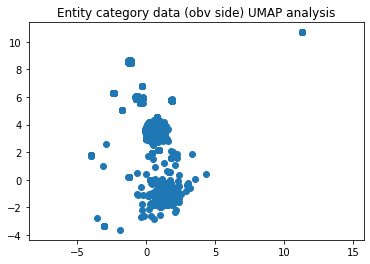

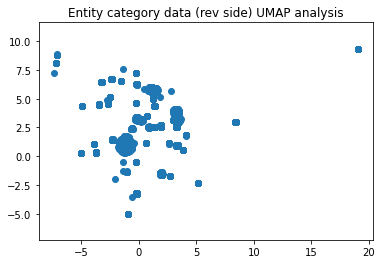

In [64]:
plt.scatter(
    x_cat_entity_obv,
    y_cat_entity_obv)
plt.gca().set_aspect('equal', 'datalim')
plt.title("Entity category data (obv side) UMAP analysis")
plt.show()
plt.scatter(
    x_cat_entity_rev,
    y_cat_entity_rev)
plt.gca().set_aspect('equal', 'datalim')
plt.title("Entity category data (rev side) UMAP analysis")
plt.show()

<h2> 3.2 t-SNE analysis </h2>

In [65]:
tsne_entity_cat_ob = TSNE(n_components=2, verbose=2, perplexity=20, n_iter=1000, learning_rate=10)
tsne_results_entity_cat_obv = tsne_entity_cat_ob.fit_transform(entity_cat_data_obv)
tsne_entity_cat_rev = TSNE(n_components=2, verbose=2, perplexity=20, n_iter=1000, learning_rate=10)
tsne_results_entity_cat_rev = tsne_entity_cat_rev.fit_transform(entity_cat_data_rev)

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 28581 samples in 0.773s...
[t-SNE] Computed neighbors for 28581 samples in 6.966s...
[t-SNE] Computed conditional probabilities for sample 1000 / 28581
[t-SNE] Computed conditional probabilities for sample 2000 / 28581
[t-SNE] Computed conditional probabilities for sample 3000 / 28581
[t-SNE] Computed conditional probabilities for sample 4000 / 28581
[t-SNE] Computed conditional probabilities for sample 5000 / 28581
[t-SNE] Computed conditional probabilities for sample 6000 / 28581
[t-SNE] Computed conditional probabilities for sample 7000 / 28581
[t-SNE] Computed conditional probabilities for sample 8000 / 28581
[t-SNE] Computed conditional probabilities for sample 9000 / 28581
[t-SNE] Computed conditional probabilities for sample 10000 / 28581
[t-SNE] Computed conditional probabilities for sample 11000 / 28581
[t-SNE] Computed conditional probabilities for sample 12000 / 28581
[t-SNE] Computed conditional probabilities for sam

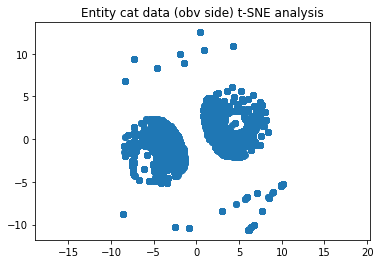

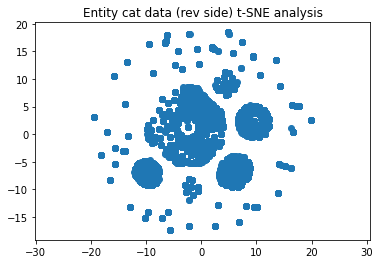

In [66]:
plt.scatter(
    tsne_results_entity_cat_obv[:, 0],
    tsne_results_entity_cat_obv[:, 1])
plt.gca().set_aspect('equal', 'datalim')
plt.title("Entity cat data (obv side) t-SNE analysis")
plt.show()
plt.scatter(
    tsne_results_entity_cat_rev[:, 0],
    tsne_results_entity_cat_rev[:, 1])
plt.gca().set_aspect('equal', 'datalim')
plt.title("Entity cat data (rev side) t-SNE analysis")
plt.show()

<h2>3.3 PCA analysis </h2>

In [67]:
pca_entity_cat_obv = PCA(n_components=2)
pca_entity_cat_obv.fit(entity_cat_data_obv)
pca_results_entity_cat_obv = pca_entity_cat_obv.transform(entity_cat_data_obv)

pca_entity_cat_rev = PCA(n_components=2)
pca_entity_cat_rev.fit(entity_cat_data_rev)
pca_results_entity_cat_rev = pca_entity_cat_rev.transform(entity_cat_data_rev)

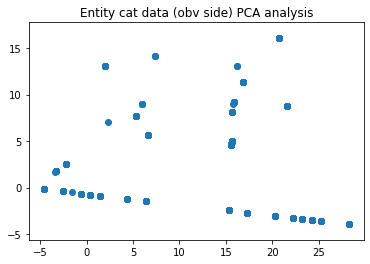

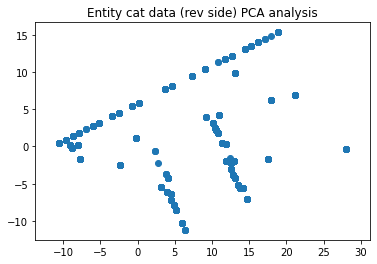

In [68]:
plt.scatter(
    pca_results_entity_cat_obv[:, 0],
    pca_results_entity_cat_obv[:, 1])
plt.gca().set_aspect('equal', 'datalim')
plt.title("Entity cat data (obv side) PCA analysis")
plt.show()
plt.scatter(
    pca_results_entity_cat_rev[:, 0],
    pca_results_entity_cat_rev[:, 1])
plt.gca().set_aspect('equal', 'datalim')
plt.title("Entity cat data (rev side) PCA analysis")
plt.show()

<h1> 4. Join coin data with entity dummys </h1>

<h2> 4.1 Full data with entity dummys - UMAP </h2>

In [32]:
data["coin"] = data_coins
entity_dummys["coin"] = entity_coins
data_w_entity_dummys = pd.merge(data, entity_dummys, how="left", on="coin")
data_w_entity_dummys = data_w_entity_dummys.dropna()

In [33]:
del data_w_entity_dummys["coin"]
del data_w_entity_dummys["collection_cat"]
data_w_entity_dummys.columns

Index(['maxdiam', 'mindiam', 'weight', 'material', 'enddate', 'startdate',
       'axis', 'denom_cat', 'mint_cat', 'entity_Abundantia',
       ...
       'entity_Zügel', 'entity_cista mystica', 'entity_keltischen',
       'entity_Ägis', 'entity_Ähre', 'entity_Ähren', 'entity_Ährenkranz',
       'entity_Ährenkranzes', 'entity_Äpfel', 'entity_Äpfeln'],
      dtype='object', length=579)

In [34]:
data_w_entity_dummys.shape
scaler = StandardScaler()
scaler.fit(data_w_entity_dummys)
data_w_entity_dummys_standardized = scaler.transform(data_w_entity_dummys)

In [35]:
umap_data_w_entity_x, umap_data_w_entity_y = cross_validation(data_w_entity_dummys_standardized, 20) 

c:\users\fredi\anaconda3\envs\ftp\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
c:\users\fredi\anaconda3\envs\ftp\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
c:\users\fredi\anaconda3\envs\ftp\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
c:\users\fredi\anaconda3\envs\ftp\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral emb

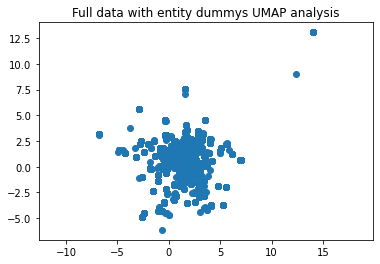

In [36]:
plt.scatter(
    umap_data_w_entity_x,
    umap_data_w_entity_y)
plt.gca().set_aspect('equal', 'datalim')
plt.title("Full data with entity dummys UMAP analysis")
plt.show()

<h3> 4.1.2 Full data with entity dummys - t-SNE </h3>

In [60]:
data_w_entity_dummys.columns

Index(['maxdiam', 'mindiam', 'weight', 'material', 'enddate', 'startdate',
       'axis', 'denom_cat', 'mint_cat', 'entity_Abundantia',
       ...
       'entity_Zügel', 'entity_cista mystica', 'entity_keltischen',
       'entity_Ägis', 'entity_Ähre', 'entity_Ähren', 'entity_Ährenkranz',
       'entity_Ährenkranzes', 'entity_Äpfel', 'entity_Äpfeln'],
      dtype='object', length=579)

In [37]:
tsne_full_entity_dummys = TSNE(n_components=2, verbose=2, perplexity=40, n_iter=1000, learning_rate=10)
tsne_results_full_entity_dummys = tsne_full_entity_dummys.fit_transform(data_w_entity_dummys_standardized)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5168 samples in 0.923s...
[t-SNE] Computed neighbors for 5168 samples in 26.009s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5168
[t-SNE] Computed conditional probabilities for sample 2000 / 5168
[t-SNE] Computed conditional probabilities for sample 3000 / 5168
[t-SNE] Computed conditional probabilities for sample 4000 / 5168
[t-SNE] Computed conditional probabilities for sample 5000 / 5168
[t-SNE] Computed conditional probabilities for sample 5168 / 5168
[t-SNE] Mean sigma: 2.216794
[t-SNE] Computed conditional probabilities in 0.277s
[t-SNE] Iteration 50: error = 86.1324997, gradient norm = 0.0000098 (50 iterations in 1.965s)
[t-SNE] Iteration 100: error = 86.0301285, gradient norm = 0.0018219 (50 iterations in 2.528s)
[t-SNE] Iteration 150: error = 83.6136093, gradient norm = 0.0014576 (50 iterations in 2.233s)
[t-SNE] Iteration 200: error = 82.4777374, gradient norm = 0.0003823 (50 iterations in 1.853s)


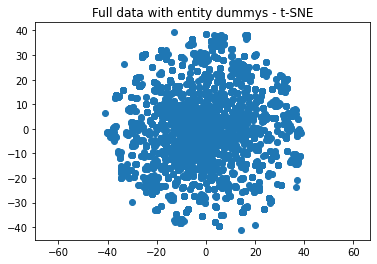

In [38]:
plt.scatter(
    tsne_results_full_entity_dummys[:, 0],
    tsne_results_full_entity_dummys[:, 1])
plt.gca().set_aspect('equal', 'datalim')
plt.title("Full data with entity dummys - t-SNE")
plt.show()

<h2> 4.2 Analyzing subsets of full data with entity dummys </h2>

In [13]:
data_w_entity_dummys_selection1 = pd.merge(data, entity_dummys, how="left", on="coin")
data_w_entity_dummys_selection1.columns

Index(['maxdiam', 'mindiam', 'weight', 'material', 'enddate', 'startdate',
       'axis', 'denom_cat', 'mint_cat', 'collection_cat',
       ...
       'entity_Zügel', 'entity_cista mystica', 'entity_keltischen',
       'entity_Ägis', 'entity_Ähre', 'entity_Ähren', 'entity_Ährenkranz',
       'entity_Ährenkranzes', 'entity_Äpfel', 'entity_Äpfeln'],
      dtype='object', length=581)

In [14]:
data_w_entity_dummys_selection1 = data_w_entity_dummys_selection1.drop(["mindiam", "weight", "startdate", "axis", "collection_cat"], axis=1)

In [15]:
data_w_entity_dummys_selection1 = data_w_entity_dummys_selection1.dropna()
del data_w_entity_dummys_selection1["coin"]

In [54]:
umap_data_w_entity_selection1_x, umap_data_w_entity_selection1_y = cross_validation(data_w_entity_dummys_selection1, 20) 

c:\users\fredi\anaconda3\envs\ftp\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
c:\users\fredi\anaconda3\envs\ftp\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
c:\users\fredi\anaconda3\envs\ftp\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
c:\users\fredi\anaconda3\envs\ftp\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral emb

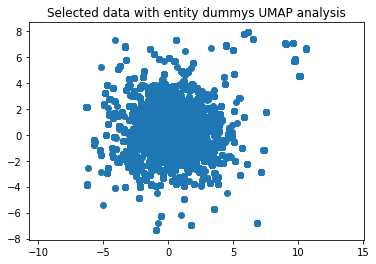

In [55]:
plt.scatter(
    umap_data_w_entity_selection1_x,
    umap_data_w_entity_selection1_y)
plt.gca().set_aspect('equal', 'datalim')
plt.title("Selected data with entity dummys UMAP analysis")
plt.show()

<h3>4.2.2 Selected data with entity dummys - t-SNE</h3>

In [63]:
tsne_full_entity_dummys_selection1 = TSNE(n_components=2, verbose=2, perplexity=40, n_iter=1000, learning_rate=10)
tsne_results_full_entity_dummys_selection1 = tsne_full_entity_dummys_selection1.fit_transform(data_w_entity_dummys_selection1)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 24302 samples in 6.882s...
[t-SNE] Computed neighbors for 24302 samples in 27.535s...
[t-SNE] Computed conditional probabilities for sample 1000 / 24302
[t-SNE] Computed conditional probabilities for sample 2000 / 24302
[t-SNE] Computed conditional probabilities for sample 3000 / 24302
[t-SNE] Computed conditional probabilities for sample 4000 / 24302
[t-SNE] Computed conditional probabilities for sample 5000 / 24302
[t-SNE] Computed conditional probabilities for sample 6000 / 24302
[t-SNE] Computed conditional probabilities for sample 7000 / 24302
[t-SNE] Computed conditional probabilities for sample 8000 / 24302
[t-SNE] Computed conditional probabilities for sample 9000 / 24302
[t-SNE] Computed conditional probabilities for sample 10000 / 24302
[t-SNE] Computed conditional probabilities for sample 11000 / 24302
[t-SNE] Computed conditional probabilities for sample 12000 / 24302
[t-SNE] Computed conditional probabilities for s

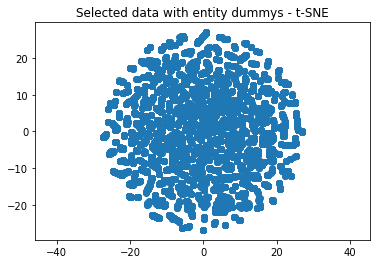

In [64]:
plt.scatter(
    tsne_results_full_entity_dummys_selection1[:, 0],
    tsne_results_full_entity_dummys_selection1[:, 1])
plt.gca().set_aspect('equal', 'datalim')
plt.title("Selected data with entity dummys - t-SNE")
plt.show()

<h2> 4.3 Analyzing full data with Top100 entity dummys - UMAP </h2>

In [22]:
tmp_e = [ x for x in data_w_entity_dummys.columns if "entity" in x]
other_entitys = [x for x in tmp_e if x not in top100_entities]
print(len(other_entitys))

470


In [23]:
data_w_entity_dummys_selection2 = data_w_entity_dummys.copy()
data_w_entity_dummys_selection2 = data_w_entity_dummys_selection2.drop(other_entitys, axis=1)
data_w_entity_dummys_selection2.columns

Index(['maxdiam', 'mindiam', 'weight', 'material', 'enddate', 'startdate',
       'axis', 'denom_cat', 'mint_cat', 'entity_Adler',
       ...
       'entity_Trauben', 'entity_Tyche', 'entity_Weinrebe',
       'entity_Weintraube', 'entity_Zepter', 'entity_Zeus',
       'entity_Ziegenbock', 'entity_Ähre', 'entity_Ähren',
       'entity_Ährenkranz'],
      dtype='object', length=109)

In [48]:
umap_data_w_entity_selection2_x, umap_data_w_entity_selection2_y = cross_validation(data_w_entity_dummys_selection2, 20) 

c:\users\fredi\anaconda3\envs\ftp\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
c:\users\fredi\anaconda3\envs\ftp\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
c:\users\fredi\anaconda3\envs\ftp\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
c:\users\fredi\anaconda3\envs\ftp\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral emb

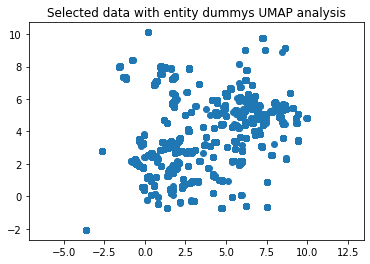

In [49]:
plt.scatter(
    umap_data_w_entity_selection2_x,
    umap_data_w_entity_selection2_y)
plt.gca().set_aspect('equal', 'datalim')
plt.title("Selected data with entity dummys UMAP analysis")
plt.show()

<h3>4.2.2 Full data with top 100 entitys - t-SNE</h3>

In [65]:
tsne_full_entity_dummys_selection2 = TSNE(n_components=2, verbose=2, perplexity=40, n_iter=1000, learning_rate=10)
tsne_results_full_entity_dummys_selection2 = tsne_full_entity_dummys_selection2.fit_transform(data_w_entity_dummys_selection2)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5168 samples in 0.156s...
[t-SNE] Computed neighbors for 5168 samples in 0.802s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5168
[t-SNE] Computed conditional probabilities for sample 2000 / 5168
[t-SNE] Computed conditional probabilities for sample 3000 / 5168
[t-SNE] Computed conditional probabilities for sample 4000 / 5168
[t-SNE] Computed conditional probabilities for sample 5000 / 5168
[t-SNE] Computed conditional probabilities for sample 5168 / 5168
[t-SNE] Mean sigma: 6.681889
[t-SNE] Computed conditional probabilities in 0.301s
[t-SNE] Iteration 50: error = 87.1186142, gradient norm = 0.0000042 (50 iterations in 1.772s)
[t-SNE] Iteration 100: error = 86.6906509, gradient norm = 0.0062157 (50 iterations in 1.551s)
[t-SNE] Iteration 150: error = 67.4863510, gradient norm = 0.0046412 (50 iterations in 1.339s)
[t-SNE] Iteration 200: error = 61.5312004, gradient norm = 0.0027312 (50 iterations in 1.365s)
[

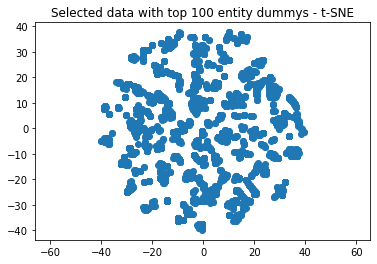

In [66]:
plt.scatter(
    tsne_results_full_entity_dummys_selection2[:, 0],
    tsne_results_full_entity_dummys_selection2[:, 1])
plt.gca().set_aspect('equal', 'datalim')
plt.title("Selected data with top 100 entity dummys - t-SNE")
plt.show()

<h2> 4.3 Analyzing selected data with top 100 dummys </h2>

In [24]:
data_w_entity_dummys_selection3 = data_w_entity_dummys_selection1.copy()
data_w_entity_dummys_selection3 = data_w_entity_dummys_selection3.drop(other_entitys, axis=1)
data_w_entity_dummys_selection3.columns

NameError: name 'data_w_entity_dummys_selection1' is not defined

In [58]:
umap_data_w_entity_selection3_x, umap_data_w_entity_selection3_y = cross_validation(data_w_entity_dummys_selection3, 20) 

c:\users\fredi\anaconda3\envs\ftp\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
c:\users\fredi\anaconda3\envs\ftp\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
c:\users\fredi\anaconda3\envs\ftp\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
c:\users\fredi\anaconda3\envs\ftp\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral emb

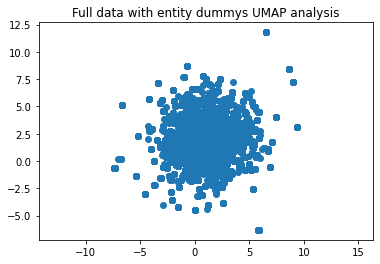

In [68]:
plt.scatter(
    umap_data_w_entity_selection3_x,
    umap_data_w_entity_selection3_y)
plt.gca().set_aspect('equal', 'datalim')
plt.title("Full data with entity dummys UMAP analysis")
plt.show()

<h3> 4.3.2 Selected data with top100 entity dummys - t-SNE</h3>

In [67]:
tsne_full_entity_dummys_selection3 = TSNE(n_components=2, verbose=2, perplexity=40, n_iter=1000, learning_rate=10)
tsne_results_full_entity_dummys_selection3 = tsne_full_entity_dummys_selection3.fit_transform(data_w_entity_dummys_selection3)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 24302 samples in 0.917s...
[t-SNE] Computed neighbors for 24302 samples in 7.919s...
[t-SNE] Computed conditional probabilities for sample 1000 / 24302
[t-SNE] Computed conditional probabilities for sample 2000 / 24302
[t-SNE] Computed conditional probabilities for sample 3000 / 24302
[t-SNE] Computed conditional probabilities for sample 4000 / 24302
[t-SNE] Computed conditional probabilities for sample 5000 / 24302
[t-SNE] Computed conditional probabilities for sample 6000 / 24302
[t-SNE] Computed conditional probabilities for sample 7000 / 24302
[t-SNE] Computed conditional probabilities for sample 8000 / 24302
[t-SNE] Computed conditional probabilities for sample 9000 / 24302
[t-SNE] Computed conditional probabilities for sample 10000 / 24302
[t-SNE] Computed conditional probabilities for sample 11000 / 24302
[t-SNE] Computed conditional probabilities for sample 12000 / 24302
[t-SNE] Computed conditional probabilities for sa

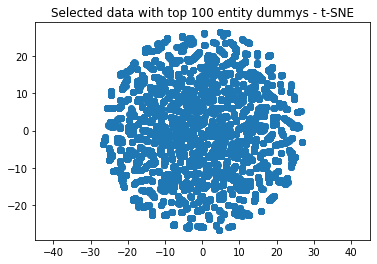

In [90]:
plt.scatter(
    tsne_results_full_entity_dummys_selection3[:, 0],
    tsne_results_full_entity_dummys_selection3[:, 1])
plt.gca().set_aspect('equal', 'datalim')
plt.title("Selected data with top 100 entity dummys - t-SNE")
plt.show()

<h1> 5. Join Entity Category with coin data </h1>

In [25]:
entity_cat_data["coin"] = entity_cat_coins
data_w_entity_cat = pd.merge(data, entity_cat_data, how="left", on="coin")


In [26]:
data_w_entity_cat = data_w_entity_cat.dropna()
del data_w_entity_cat["coin"]
data_w_entity_cat.columns

Index(['maxdiam', 'mindiam', 'weight', 'material', 'enddate', 'startdate',
       'axis', 'denom_cat', 'mint_cat', 'collection_cat', 'side', 'Cat_I',
       'Cat_II', 'Cat_III', 'Cat_IV', 'Cat_V'],
      dtype='object')

<h2> 5.1 Full data with both sides entity category data - UMAP </h2>

In [76]:
umap_data_w_entity_cat_x, umap_data_w_entity_cat_y = cross_validation(data_w_entity_cat, 20) 

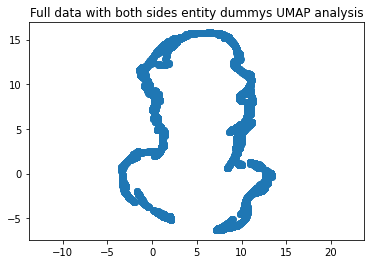

In [88]:
plt.scatter(
    umap_data_w_entity_cat_x,
    umap_data_w_entity_cat_y)
plt.gca().set_aspect('equal', 'datalim')
plt.title("Full data with both sides entity dummys UMAP analysis")
plt.show()

<b> Delete collection_cat due to pseudo id behaviour </b>

c:\users\fredi\anaconda3\envs\ftp\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
c:\users\fredi\anaconda3\envs\ftp\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
c:\users\fredi\anaconda3\envs\ftp\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
c:\users\fredi\anaconda3\envs\ftp\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral emb

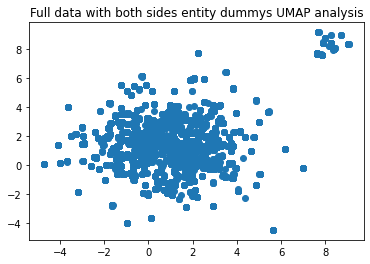

In [86]:
del data_w_entity_cat["collection_cat"]
umap_data_w_entity_cat_x_no_collection, umap_data_w_entity_cat_y_no_collection = cross_validation(data_w_entity_cat, 20)
plt.scatter(
    umap_data_w_entity_cat_x_no_collection,
    umap_data_w_entity_cat_y_no_collection)

plt.title("Full data with both sides entity dummys UMAP analysis")
plt.show()

<h2> 5.1.1 Full data with both sides entity category data - t-SNE </h2>

In [30]:
#del data_w_entity_cat["collection_cat"]
tsne_full_entity_cats = TSNE(n_components=2, verbose=2, perplexity=40, n_iter=1000, learning_rate=10)
tsne_results_full_entity_cats = tsne_full_entity_cats.fit_transform(data_w_entity_cat)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10083 samples in 0.048s...
[t-SNE] Computed neighbors for 10083 samples in 0.549s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10083
[t-SNE] Computed conditional probabilities for sample 2000 / 10083
[t-SNE] Computed conditional probabilities for sample 3000 / 10083
[t-SNE] Computed conditional probabilities for sample 4000 / 10083
[t-SNE] Computed conditional probabilities for sample 5000 / 10083
[t-SNE] Computed conditional probabilities for sample 6000 / 10083
[t-SNE] Computed conditional probabilities for sample 7000 / 10083
[t-SNE] Computed conditional probabilities for sample 8000 / 10083
[t-SNE] Computed conditional probabilities for sample 9000 / 10083
[t-SNE] Computed conditional probabilities for sample 10000 / 10083
[t-SNE] Computed conditional probabilities for sample 10083 / 10083
[t-SNE] Mean sigma: 6.033024
[t-SNE] Computed conditional probabilities in 0.578s
[t-SNE] Iteration 50: error = 95.11

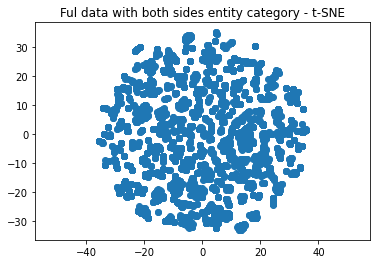

In [31]:
plt.scatter(
    tsne_results_full_entity_cats[:, 0],
    tsne_results_full_entity_cats[:, 1])
plt.gca().set_aspect('equal', 'datalim')
plt.title("Ful data with both sides entity category - t-SNE")
plt.show()

<h3> 5.1.2 Full data with entity cat side seperated - UMAP </h3>

In [33]:
data_w_entity_cat_obv = data_w_entity_cat[data_w_entity_cat["side"]==0]
data_w_entity_cat_rev = data_w_entity_cat[data_w_entity_cat["side"]==1]
del data_w_entity_cat_obv["side"]
del data_w_entity_cat_rev["side"]



In [ ]:
umap_data_w_entity_cat_x_obv, umap_data_w_entity_cat_y_obv = cross_validation(data_w_entity_cat_obv, 20)
umap_data_w_entity_cat_x_rev, umap_data_w_entity_cat_y_rev = cross_validation(data_w_entity_cat_rev, 20)

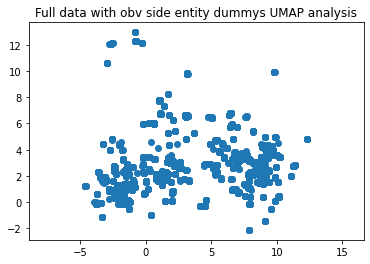

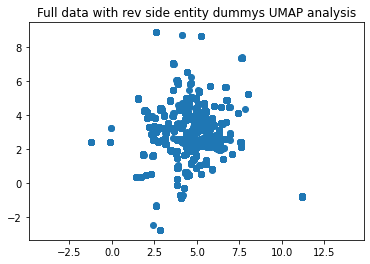

In [92]:
plt.scatter(
    umap_data_w_entity_cat_x_obv,
    umap_data_w_entity_cat_y_obv)
plt.gca().set_aspect('equal', 'datalim')
plt.title("Full data with obv side entity dummys UMAP analysis")
plt.show()
plt.scatter(
    umap_data_w_entity_cat_x_rev,
    umap_data_w_entity_cat_y_rev)
plt.gca().set_aspect('equal', 'datalim')
plt.title("Full data with rev side entity dummys UMAP analysis")
plt.show()

<h2>5.1.3 Full data with entity category sides seperated - t-SNE </h2>

In [34]:
tsne_full_entity_cats_rev = TSNE(n_components=2, verbose=2, perplexity=20, n_iter=1000, learning_rate=10)
tsne_results_full_entity_cats_rev = tsne_full_entity_cats_rev.fit_transform(data_w_entity_cat_rev)
tsne_full_entity_cats_obv = TSNE(n_components=2, verbose=2, perplexity=20, n_iter=1000, learning_rate=10)
tsne_results_full_entity_cats_obv = tsne_full_entity_cats_obv.fit_transform(data_w_entity_cat_obv)

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 4946 samples in 0.026s...
[t-SNE] Computed neighbors for 4946 samples in 0.135s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4946
[t-SNE] Computed conditional probabilities for sample 2000 / 4946
[t-SNE] Computed conditional probabilities for sample 3000 / 4946
[t-SNE] Computed conditional probabilities for sample 4000 / 4946
[t-SNE] Computed conditional probabilities for sample 4946 / 4946
[t-SNE] Mean sigma: 5.337189
[t-SNE] Computed conditional probabilities in 0.130s
[t-SNE] Iteration 50: error = 94.8586426, gradient norm = 0.0000091 (50 iterations in 1.216s)
[t-SNE] Iteration 100: error = 92.5082397, gradient norm = 0.0108803 (50 iterations in 2.129s)
[t-SNE] Iteration 150: error = 72.6763840, gradient norm = 0.0051303 (50 iterations in 1.264s)
[t-SNE] Iteration 200: error = 67.0617676, gradient norm = 0.0030978 (50 iterations in 1.131s)
[t-SNE] Iteration 250: error = 64.1929703, gradient norm = 0.0022499

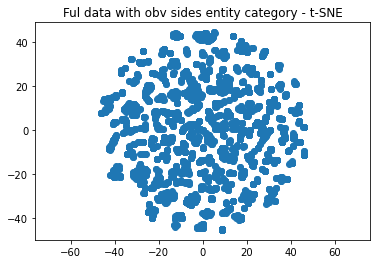

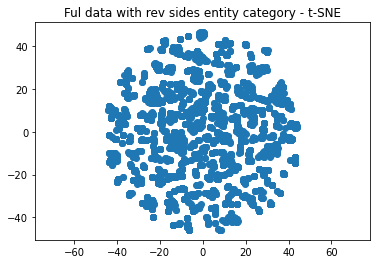

In [35]:
plt.scatter(
    tsne_results_full_entity_cats_obv[:, 0],
    tsne_results_full_entity_cats_obv[:, 1])
plt.gca().set_aspect('equal', 'datalim')
plt.title("Ful data with obv sides entity category - t-SNE")
plt.show()
plt.scatter(
    tsne_results_full_entity_cats_rev[:, 0],
    tsne_results_full_entity_cats_rev[:, 1])
plt.gca().set_aspect('equal', 'datalim')
plt.title("Ful data with rev sides entity category - t-SNE")
plt.show()

<h2> 5.1 Reduced data with both sides entity category data - UMAP </h2>

In [28]:
selected_data_w_entity_cat = pd.merge(data, entity_cat_data, how="left", on="coin")
selected_data_w_entity_cat = selected_data_w_entity_cat.drop(["mindiam", "weight", "startdate", "axis", "collection_cat"], axis=1)
selected_data_w_entity_cat = selected_data_w_entity_cat.dropna()
del selected_data_w_entity_cat["coin"]
selected_data_w_entity_cat.columns

Index(['maxdiam', 'material', 'enddate', 'denom_cat', 'mint_cat', 'side',
       'Cat_I', 'Cat_II', 'Cat_III', 'Cat_IV', 'Cat_V'],
      dtype='object')

In [95]:
umap_selected_data_w_entity_cat_x, umap_selected_data_w_entity_cat_y = cross_validation(selected_data_w_entity_cat, 20)

c:\users\fredi\anaconda3\envs\ftp\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
c:\users\fredi\anaconda3\envs\ftp\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
c:\users\fredi\anaconda3\envs\ftp\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
c:\users\fredi\anaconda3\envs\ftp\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral emb

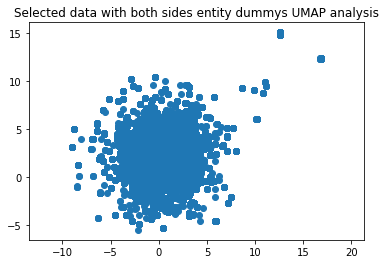

In [96]:
plt.scatter(
    umap_selected_data_w_entity_cat_x,
    umap_selected_data_w_entity_cat_y)
plt.gca().set_aspect('equal', 'datalim')
plt.title("Selected data with both sides entity category UMAP analysis")
plt.show()

<h3> 5.1.1 Reduced data with both sides entity category data - t-SNE </h3>

In [38]:
tsne_selected_entity_cats = TSNE(n_components=2, verbose=2, perplexity=20, n_iter=1000, learning_rate=10)
tsne_resutls_selected_entity_cats = tsne_selected_entity_cats.fit_transform(selected_data_w_entity_cat)

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 45586 samples in 0.213s...
[t-SNE] Computed neighbors for 45586 samples in 2.894s...
[t-SNE] Computed conditional probabilities for sample 1000 / 45586
[t-SNE] Computed conditional probabilities for sample 2000 / 45586
[t-SNE] Computed conditional probabilities for sample 3000 / 45586
[t-SNE] Computed conditional probabilities for sample 4000 / 45586
[t-SNE] Computed conditional probabilities for sample 5000 / 45586
[t-SNE] Computed conditional probabilities for sample 6000 / 45586
[t-SNE] Computed conditional probabilities for sample 7000 / 45586
[t-SNE] Computed conditional probabilities for sample 8000 / 45586
[t-SNE] Computed conditional probabilities for sample 9000 / 45586
[t-SNE] Computed conditional probabilities for sample 10000 / 45586
[t-SNE] Computed conditional probabilities for sample 11000 / 45586
[t-SNE] Computed conditional probabilities for sample 12000 / 45586
[t-SNE] Computed conditional probabilities for sam

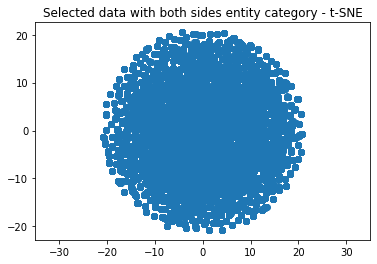

In [39]:
plt.scatter(
    tsne_resutls_selected_entity_cats[:, 0],
    tsne_resutls_selected_entity_cats[:, 1])
plt.gca().set_aspect('equal', 'datalim')
plt.title("Selected data with both sides entity category - t-SNE")
plt.show()

<h3> 5.1.2 selected data with entity category and seperated sides - UMAP  </h3>

In [29]:
selected_data_w_entity_cat_obv = selected_data_w_entity_cat[selected_data_w_entity_cat["side"]==0]
selected_data_w_entity_cat_rev = selected_data_w_entity_cat[selected_data_w_entity_cat["side"]==1]
del selected_data_w_entity_cat_obv["side"]
del selected_data_w_entity_cat_rev["side"]

c:\users\fredi\anaconda3\envs\ftp\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
c:\users\fredi\anaconda3\envs\ftp\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
c:\users\fredi\anaconda3\envs\ftp\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
c:\users\fredi\anaconda3\envs\ftp\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral emb

c:\users\fredi\anaconda3\envs\ftp\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
c:\users\fredi\anaconda3\envs\ftp\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
c:\users\fredi\anaconda3\envs\ftp\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
c:\users\fredi\anaconda3\envs\ftp\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral emb

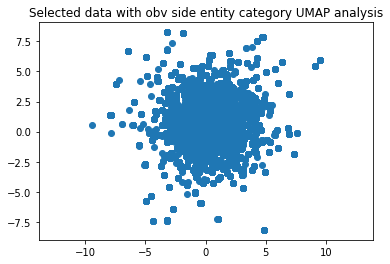

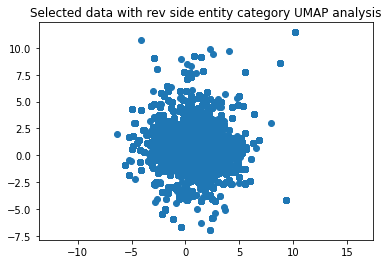

In [97]:

umap_selected_data_w_entity_cat_x_obv, umap_selected_data_w_entity_cat_y_obv = cross_validation(selected_data_w_entity_cat_obv, 20)
umap_selected_data_w_entity_cat_x_rev, umap_selected_data_w_entity_cat_y_rev = cross_validation(selected_data_w_entity_cat_rev, 20)

plt.scatter(
    umap_selected_data_w_entity_cat_x_obv,
    umap_selected_data_w_entity_cat_y_obv)
plt.gca().set_aspect('equal', 'datalim')
plt.title("Selected data with obv side entity category UMAP analysis")
plt.show()
plt.scatter(
    umap_selected_data_w_entity_cat_x_rev,
    umap_selected_data_w_entity_cat_y_rev)
plt.gca().set_aspect('equal', 'datalim')
plt.title("Selected data with rev side entity category UMAP analysis")
plt.show()


<h3> 5.1.2 selected data with entity category and seperated sides - t-SNE  </h3>

In [41]:
tsne_selected_entity_cats_obv = TSNE(n_components=2, verbose=2, perplexity=20, n_iter=1000, learning_rate=10)
tsne_resutls_selected_entity_cats_obv = tsne_selected_entity_cats_obv.fit_transform(selected_data_w_entity_cat_obv)
tsne_selected_entity_cats_rev = TSNE(n_components=2, verbose=2, perplexity=20, n_iter=1000, learning_rate=10)
tsne_resutls_selected_entity_cats_rev = tsne_selected_entity_cats_rev.fit_transform(selected_data_w_entity_cat_rev)

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 24019 samples in 0.091s...
[t-SNE] Computed neighbors for 24019 samples in 0.788s...
[t-SNE] Computed conditional probabilities for sample 1000 / 24019
[t-SNE] Computed conditional probabilities for sample 2000 / 24019
[t-SNE] Computed conditional probabilities for sample 3000 / 24019
[t-SNE] Computed conditional probabilities for sample 4000 / 24019
[t-SNE] Computed conditional probabilities for sample 5000 / 24019
[t-SNE] Computed conditional probabilities for sample 6000 / 24019
[t-SNE] Computed conditional probabilities for sample 7000 / 24019
[t-SNE] Computed conditional probabilities for sample 8000 / 24019
[t-SNE] Computed conditional probabilities for sample 9000 / 24019
[t-SNE] Computed conditional probabilities for sample 10000 / 24019
[t-SNE] Computed conditional probabilities for sample 11000 / 24019
[t-SNE] Computed conditional probabilities for sample 12000 / 24019
[t-SNE] Computed conditional probabilities for sam

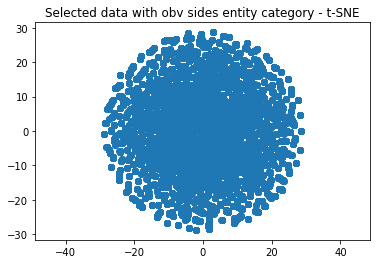

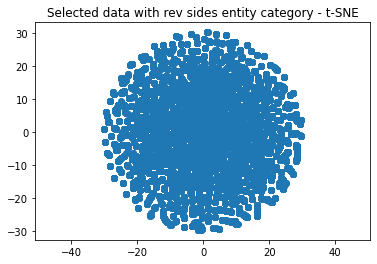

In [42]:
plt.scatter(
    tsne_resutls_selected_entity_cats_obv[:, 0],
    tsne_resutls_selected_entity_cats_obv[:, 1])
plt.gca().set_aspect('equal', 'datalim')
plt.title("Selected data with obv sides entity category - t-SNE")
plt.show()
plt.scatter(
    tsne_resutls_selected_entity_cats_rev[:, 0],
    tsne_resutls_selected_entity_cats_rev[:, 1])
plt.gca().set_aspect('equal', 'datalim')
plt.title("Selected data with rev sides entity category - t-SNE")
plt.show()

<h3> 5.1.3 selected data with entity category and seperated sides - PCA </h3>

In [43]:
pca_selected_data_entity_cat_obv = PCA(n_components=2)
pca_selected_data_entity_cat_obv.fit(selected_data_w_entity_cat_obv)
pca_results_selected_data_entity_cat_obv = pca_selected_data_entity_cat_obv.transform(selected_data_w_entity_cat_obv)

pca_entity_selected_data_cat_rev = PCA(n_components=2)
pca_entity_selected_data_cat_rev.fit(selected_data_w_entity_cat_rev)
pca_results_selected_data_entity_cat_rev = pca_entity_selected_data_cat_rev.transform(selected_data_w_entity_cat_rev)

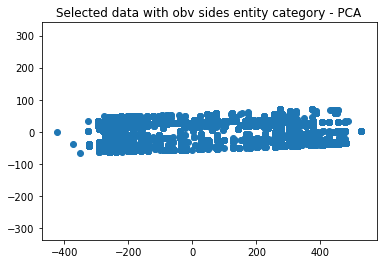

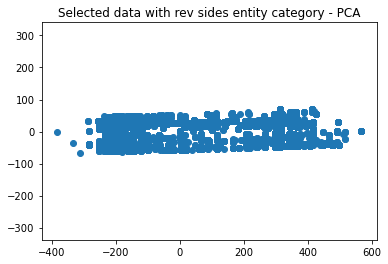

In [44]:
plt.scatter(
    pca_results_selected_data_entity_cat_obv[:, 0],
    pca_results_selected_data_entity_cat_obv[:, 1])
plt.gca().set_aspect('equal', 'datalim')
plt.title("Selected data with obv sides entity category - PCA")
plt.show()
plt.scatter(
    pca_results_selected_data_entity_cat_rev[:, 0],
    pca_results_selected_data_entity_cat_rev[:, 1])
plt.gca().set_aspect('equal', 'datalim')
plt.title("Selected data with rev sides entity category - PCA")
plt.show()

<h3> 5.1.4 selected data with entity category and seperated sides - truncated SVD </h3>

In [46]:
svd_selected_data_cat_entity_obv = TruncatedSVD(n_components=2, n_iter=500, random_state=42)
svd_selected_data_cat_entity_obv.fit(selected_data_w_entity_cat_obv)
svd_results_selected_data_cat_entity_obv= svd_selected_data_cat_entity_obv.transform(selected_data_w_entity_cat_obv)
svd_selected_data_cat_entity_rev = TruncatedSVD(n_components=2, n_iter=500, random_state=42)
svd_selected_data_cat_entity_rev.fit(selected_data_w_entity_cat_rev)
svd_results_selected_data_cat_entity_rev= svd_selected_data_cat_entity_rev.transform(selected_data_w_entity_cat_rev)

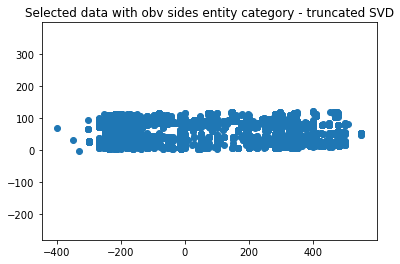

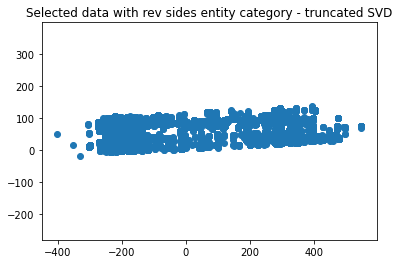

In [47]:
plt.scatter(
    svd_results_selected_data_cat_entity_obv[:, 0],
    svd_results_selected_data_cat_entity_obv[:, 1])
plt.gca().set_aspect('equal', 'datalim')
plt.title("Selected data with obv sides entity category - truncated SVD")
plt.show()
plt.scatter(
    svd_results_selected_data_cat_entity_rev[:, 0],
    svd_results_selected_data_cat_entity_rev[:, 1])
plt.gca().set_aspect('equal', 'datalim')
plt.title("Selected data with rev sides entity category - truncated SVD")
plt.show()

# 6. Predict coin variables with entity data

In [30]:
data_new = pd.read_csv('..\\data\\analysis_dataset_w_material.csv', sep=";")
entity_cat_data["coin"] = entity_cat_coins
data_new.columns
del data_new["Unnamed: 0"]
data_entity_cat_new = pd.merge(data_new, entity_cat_data, how="left", on="coin")
data_entity_cat_new.columns

Index(['coin', 'maxdiam', 'mindiam', 'weight', 'material', 'enddate',
       'startdate', 'axis', 'findspot', 'material_cat', 'denom_cat',
       'mint_cat', 'collection_cat', 'side', 'Cat_I', 'Cat_II', 'Cat_III',
       'Cat_IV', 'Cat_V'],
      dtype='object')

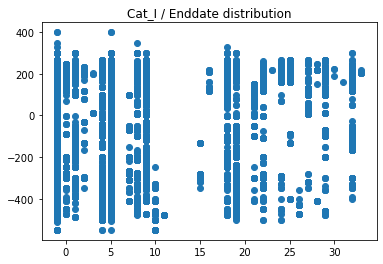

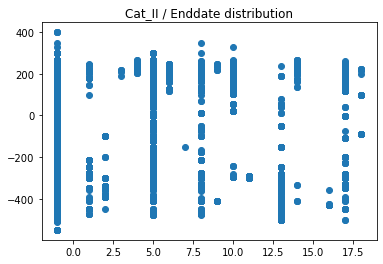

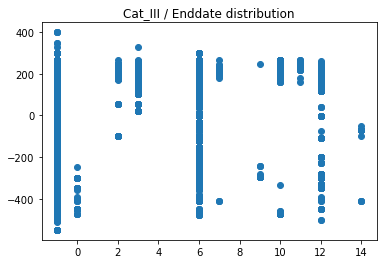

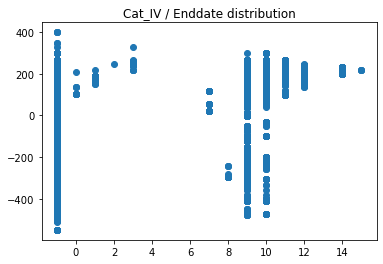

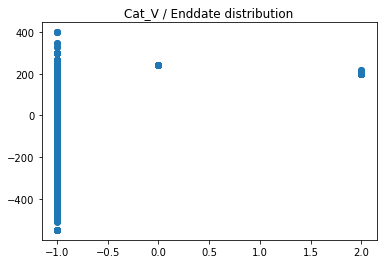

In [184]:
plt.scatter(data_entity_cat_new["Cat_I"], data_entity_cat_new["enddate"])
plt.title("Cat_I / Enddate distribution")
plt.show()
plt.scatter(data_entity_cat_new["Cat_II"], data_entity_cat_new["enddate"])
plt.title("Cat_II / Enddate distribution")
plt.show()
plt.scatter(data_entity_cat_new["Cat_III"], data_entity_cat_new["enddate"])
plt.title("Cat_III / Enddate distribution")
plt.show()
plt.scatter(data_entity_cat_new["Cat_IV"], data_entity_cat_new["enddate"])
plt.title("Cat_IV / Enddate distribution")
plt.show()
plt.scatter(data_entity_cat_new["Cat_V"], data_entity_cat_new["enddate"])
plt.title("Cat_V / Enddate distribution")
plt.show()

In [31]:
data_entity_cat_new.Cat_I.unique()

array([ 5., -1.,  9., nan, 18., 32.,  1.,  8., 25., 19.,  4.,  0.,  7.,
       16., 29., 22.,  2., 24., 21., 10., 28., 15., 27.,  3., 26., 11.,
       30., 33., 31., 23.])

In [32]:
del data_new["coin"]
data_new.columns

Index(['maxdiam', 'mindiam', 'weight', 'material', 'enddate', 'startdate',
       'axis', 'findspot', 'material_cat', 'denom_cat', 'mint_cat',
       'collection_cat'],
      dtype='object')

In [33]:
del data_new["collection_cat"]
del data_new["findspot"]
denom_dummys = pd.get_dummies(data_new["denom_cat"], prefix="denom")
material_dummys = pd.get_dummies(data_new["material_cat"], prefix="material")
mint_dummys = pd.get_dummies(data_new["mint_cat"], prefix="mint")

In [34]:
prepared_data = pd.concat([data_new, denom_dummys, material_dummys, mint_dummys], axis=1)
del prepared_data["material_cat"]
del prepared_data["denom_cat"]
del prepared_data["mint_cat"]
del prepared_data["material"]
prepared_data.columns

Index(['maxdiam', 'mindiam', 'weight', 'enddate', 'startdate', 'axis',
       'denom_-1.0', 'denom_0.0', 'denom_1.0', 'denom_2.0',
       ...
       'mint_106.0', 'mint_107.0', 'mint_108.0', 'mint_109.0', 'mint_110.0',
       'mint_111.0', 'mint_112.0', 'mint_113.0', 'mint_114.0', 'mint_115.0'],
      dtype='object', length=183)

In [35]:
prepared_data = prepared_data.dropna()
prepared_data.shape

(5947, 183)

In [37]:
y = prepared_data["enddate"]
X = prepared_data.drop(["enddate", "startdate"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
clf = RandomForestClassifier(max_depth=30, random_state=0, n_estimators=200)

clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
print(accuracy_score(y_test, y_predict))

0.4857142857142857


In [39]:
clf = RandomForestClassifier(max_depth=20, random_state=0, n_estimators=200)

clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
print(accuracy_score(y_test, y_predict))

0.4857142857142857


In [40]:
clf = RandomForestClassifier(max_depth=10, random_state=0, n_estimators=200)

clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
print(accuracy_score(y_test, y_predict))

0.4504201680672269


In [41]:
clf = RandomForestClassifier(max_depth=5, random_state=0, n_estimators=200)

clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
print(accuracy_score(y_test, y_predict))

0.29747899159663865


In [144]:

clf = RandomForestClassifier(max_depth=20, random_state=0, n_estimators=200)

clf.fit(X_train, y_train)

start_time = time.time()
importances = clf.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in clf.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.039 seconds


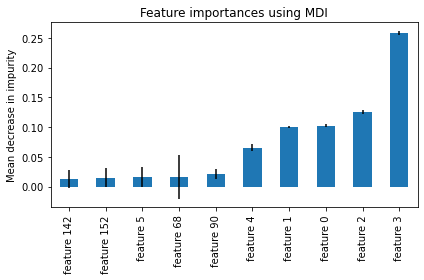

In [149]:
feature_names = [f'feature {i}' for i in range(X.shape[1])]
forest_importances = pd.Series(importances, index=feature_names)
forest_importances = forest_importances.sort_values()
forest_importances = forest_importances.tail(10)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std[:10], ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [42]:
import xgboost as xgb

In [43]:
regressor = xgb.XGBRegressor(
    n_estimators=300,
    reg_lambda=1,
    gamma=0,
    max_depth=10
)
regressor.fit(X_train, y_train)
y_predict = regressor.predict(X_test)


scores = cross_val_score(regressor, X, y, scoring='r2', cv=5)

In [44]:
scores.mean()

0.886026122316367

In [45]:
pd.DataFrame(regressor.feature_importances_.reshape(1, -1), columns=X_train.columns)

,maxdiam,mindiam,weight,axis,denom_-1.0,denom_0.0,denom_1.0,denom_2.0,denom_3.0,denom_4.0,...,mint_106.0,mint_107.0,mint_108.0,mint_109.0,mint_110.0,mint_111.0,mint_112.0,mint_113.0,mint_114.0,mint_115.0
0,0.008978,0.005354,0.001232,0.002211,0.017092,0.000317,0.003604,0.001037,0.000959,0.00081,...,0.004032,0.000005,0.001162,0.000567,0.000861,0.000028,0.000009,0.0,0.000074,0.000086


In [46]:
df_fi = pd.DataFrame({"feature": X_train.columns, "importance": regressor.feature_importances_})

In [47]:
df_fi = df_fi.sort_values("importance")
df_fi.tail(10)

,feature,importance
60,material_2.0,0.016676
4,denom_-1.0,0.017092
103,mint_38.0,0.017495
29,denom_24.0,0.018381
151,mint_86.0,0.019647
56,denom_51.0,0.021042
130,mint_65.0,0.022165
66,mint_1.0,0.052002
59,material_1.0,0.080714
58,material_0.0,0.433700


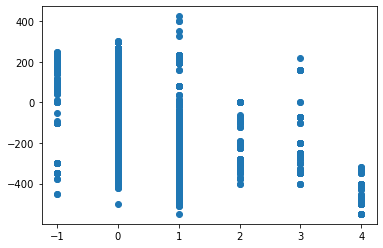

In [186]:
plt.scatter(data_new["material_cat"], data_new["enddate"])
plt.show()

In [48]:
prepared_data2 = pd.concat([data_new, denom_dummys, mint_dummys], axis=1)
del prepared_data2["denom_cat"]
del prepared_data2["mint_cat"]
del prepared_data2["material"]
prepared_data2 = prepared_data2.dropna()

y2 = prepared_data2["material_cat"]
X2 = prepared_data2.drop("material_cat", axis=1)

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)
print(X2_train.shape)
print(X2_test.shape)

(4757, 176)
(1190, 176)


In [49]:
clf = RandomForestClassifier(max_depth=50, random_state=0, n_estimators=200)

clf.fit(X2_train, y2_train)
y_predict = clf.predict(X2_test)
print(accuracy_score(y2_test, y_predict))

0.9899159663865547


In [50]:
clf = RandomForestClassifier(max_depth=20, random_state=0, n_estimators=200)

clf.fit(X2_train, y2_train)
y_predict = clf.predict(X2_test)
print(accuracy_score(y2_test, y_predict))

0.9899159663865547


In [51]:
clf = RandomForestClassifier(max_depth=10, random_state=0, n_estimators=200)

clf.fit(X2_train, y2_train)
y_predict = clf.predict(X2_test)
print(accuracy_score(y2_test, y_predict))

0.984873949579832


In [52]:
clf = RandomForestClassifier(max_depth=5, random_state=0, n_estimators=200)

clf.fit(X2_train, y2_train)
y_predict = clf.predict(X2_test)
print(accuracy_score(y2_test, y_predict))

0.9638655462184874


In [53]:
from sklearn.metrics import r2_score
from rfpimp import permutation_importances

def r2(rf, X_train, y_train):
    return r2_score(y_train, rf.predict(X_train))

perm_imp_rfpimp = permutation_importances(clf, X2_train, y2_train, r2)

c:\users\fredi\anaconda3\envs\ftp\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [59]:
perm_imp_rfpimp = perm_imp_rfpimp.sort_values("Importance")
perm_imp_rfpimp.tail(10)

,Importance
Feature,
denom_0.0,0.016764
mint_1.0,0.025146
denom_16.0,0.031133
weight,0.033528
denom_18.0,0.071845
denom_25.0,0.075437
startdate,0.213140
denom_41.0,0.229903
enddate,0.306538


In [60]:
X2_train["denom_-1.0"].sum()

2092

<h2> Try to predict certain variables with entity dummys </h2>

In [105]:
data_new = pd.read_csv('..\\data\\analysis_dataset_w_material.csv', sep=";")
entity_dummys_new = pd.read_csv("..\\2021_06_01_DC_NLP_CNT\\design_dummys.csv", sep=";")

In [106]:
del data_new["Unnamed: 0"]
del entity_dummys_new["Unnamed: 0"]
data_new_w_entity_total = pd.merge(data_new, entity_dummys_new, how="left", left_on="coin", right_on="id_coin")

In [90]:
data_new_w_entity = data_new_w_entity_total.copy()
data_new_w_entity.columns
coins = data_new_w_entity["coin"]
del data_new_w_entity["coin"]
del data_new_w_entity["id_coin"]
del data_new_w_entity["collection_cat"]
del data_new_w_entity["material"]

In [91]:
data_new_w_entity = pd.concat([data_new_w_entity, denom_dummys, material_dummys, mint_dummys], axis=1)

In [92]:
data_new_w_entity.shape

(41088, 757)

In [93]:
data_new_w_entity = data_new_w_entity.dropna()

In [94]:
data_new_w_entity.columns

Index(['maxdiam', 'mindiam', 'weight', 'enddate', 'startdate', 'axis',
       'findspot', 'material_cat', 'denom_cat', 'mint_cat',
       ...
       'mint_106.0', 'mint_107.0', 'mint_108.0', 'mint_109.0', 'mint_110.0',
       'mint_111.0', 'mint_112.0', 'mint_113.0', 'mint_114.0', 'mint_115.0'],
      dtype='object', length=757)

In [95]:
del data_new_w_entity["material_cat"]
del data_new_w_entity["denom_cat"]
del data_new_w_entity["mint_cat"]
del data_new_w_entity["findspot"]

In [96]:
y = data_new_w_entity["enddate"]
X = data_new_w_entity.drop(["enddate", "startdate"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [98]:
for col in X_train.columns:
    try:
        X_train[col] = X_train[col].astype(float)
    except:
        print(col)

c:\users\fredi\anaconda3\envs\ftp\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [99]:
clf = RandomForestClassifier(max_depth=30, random_state=0, n_estimators=200)

clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
print(accuracy_score(y_test, y_predict))

0.8355899419729207


In [100]:
entity_only = [x for x in data_new_w_entity.columns if "entity" in x]
entity_only

['entity_Abundantia',
 'entity_Acrostolium',
 'entity_Adler',
 'entity_Adlerzepter',
 'entity_Aeneas',
 'entity_Aequitas',
 'entity_Agrippa',
 'entity_Aigis',
 'entity_Alexander des Großen',
 'entity_Altar',
 'entity_Amphora',
 'entity_Anchialos',
 'entity_Anchises',
 'entity_Andromeda',
 'entity_Anker',
 'entity_Annona',
 'entity_Antinoos',
 'entity_Antiochos I. Soter',
 'entity_Antiochos II. Theos',
 'entity_Antonia',
 'entity_Antoninus Pius',
 'entity_Anubis',
 'entity_Apfel',
 'entity_Apfelbaum',
 'entity_Aphlaston',
 'entity_Aphrodite',
 'entity_Apis',
 'entity_Apollo',
 'entity_Apollon',
 'entity_Apollon Asklepios',
 'entity_Ares',
 'entity_Ariadne',
 'entity_Artemis',
 'entity_Ascanius',
 'entity_Asklepios',
 'entity_Astragal',
 'entity_Athena',
 'entity_Athleten',
 'entity_Attis',
 'entity_Augustus',
 'entity_Aulos',
 'entity_Axt',
 'entity_Balken',
 'entity_Basen',
 'entity_Basis',
 'entity_Baum',
 'entity_Baumstumpf',
 'entity_Beeren',
 'entity_Biene',
 'entity_Biga',
 'entit

In [101]:
y = data_new_w_entity["enddate"]
X = data_new_w_entity[entity_only]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [103]:
clf = RandomForestClassifier(max_depth=30, random_state=0, n_estimators=200)

clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
print(accuracy_score(y_test, y_predict))
print(r2_score(y_test, clf.predict(X_test)))

0.7688588007736944
0.9271008746464272


In [104]:
perm_imp_rfpimp = permutation_importances(clf, X_train, y_train, r2)
perm_imp_rfpimp = perm_imp_rfpimp.sort_values("Importance")
perm_imp_rfpimp.tail(10)

,Importance
Feature,
entity_Geta,0.027968
entity_Antoninus Pius,0.028093
entity_Gewand,0.028710
entity_Commodus,0.030446
entity_Paludamentum,0.034659
entity_Severus Alexander,0.038585
entity_Gordian,0.068629
entity_Septimius Severus,0.073070
entity_Brustbild,0.134040


<h2> Predict material with entity dummys only </h2>

In [109]:
data_new_w_entity_total = data_new_w_entity_total[["material_cat"]+ entity_only]
data_new_w_entity_total = data_new_w_entity_total.dropna()
for col in data_new_w_entity_total.columns:
    try:
        data_new_w_entity_total[col] = data_new_w_entity_total[col].astype(float)
    except:
        print(col)
print(data_new_w_entity_total.shape)
y = data_new_w_entity_total["material_cat"]
X = data_new_w_entity_total[entity_only]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

(28995, 571)


In [110]:
clf = RandomForestClassifier(max_depth=30, random_state=0, n_estimators=200)

clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
print(accuracy_score(y_test, y_predict))

0.9242972926366615


In [112]:
data_new_w_entity_total.groupby("material_cat").count()

,entity_Abundantia,entity_Acrostolium,entity_Adler,entity_Adlerzepter,entity_Aeneas,entity_Aequitas,entity_Agrippa,entity_Aigis,entity_Alexander des Großen,entity_Altar,...,entity_Zügel,entity_cista mystica,entity_keltischen,entity_Ägis,entity_Ähre,entity_Ähren,entity_Ährenkranz,entity_Ährenkranzes,entity_Äpfel,entity_Äpfeln
material_cat,,,,,,,,,,,,,,,,,,,,,
-1.0,608,608,608,608,608,608,608,608,608,608,...,608,608,608,608,608,608,608,608,608,608
0.0,20700,20700,20700,20700,20700,20700,20700,20700,20700,20700,...,20700,20700,20700,20700,20700,20700,20700,20700,20700,20700
1.0,6377,6377,6377,6377,6377,6377,6377,6377,6377,6377,...,6377,6377,6377,6377,6377,6377,6377,6377,6377,6377
2.0,208,208,208,208,208,208,208,208,208,208,...,208,208,208,208,208,208,208,208,208,208
3.0,168,168,168,168,168,168,168,168,168,168,...,168,168,168,168,168,168,168,168,168,168
4.0,934,934,934,934,934,934,934,934,934,934,...,934,934,934,934,934,934,934,934,934,934
